In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np 
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ExpectationMaximization
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/anaconda3/envs/pgmpy310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 


===== DATA SHAPE =====
(253680, 22)

===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253

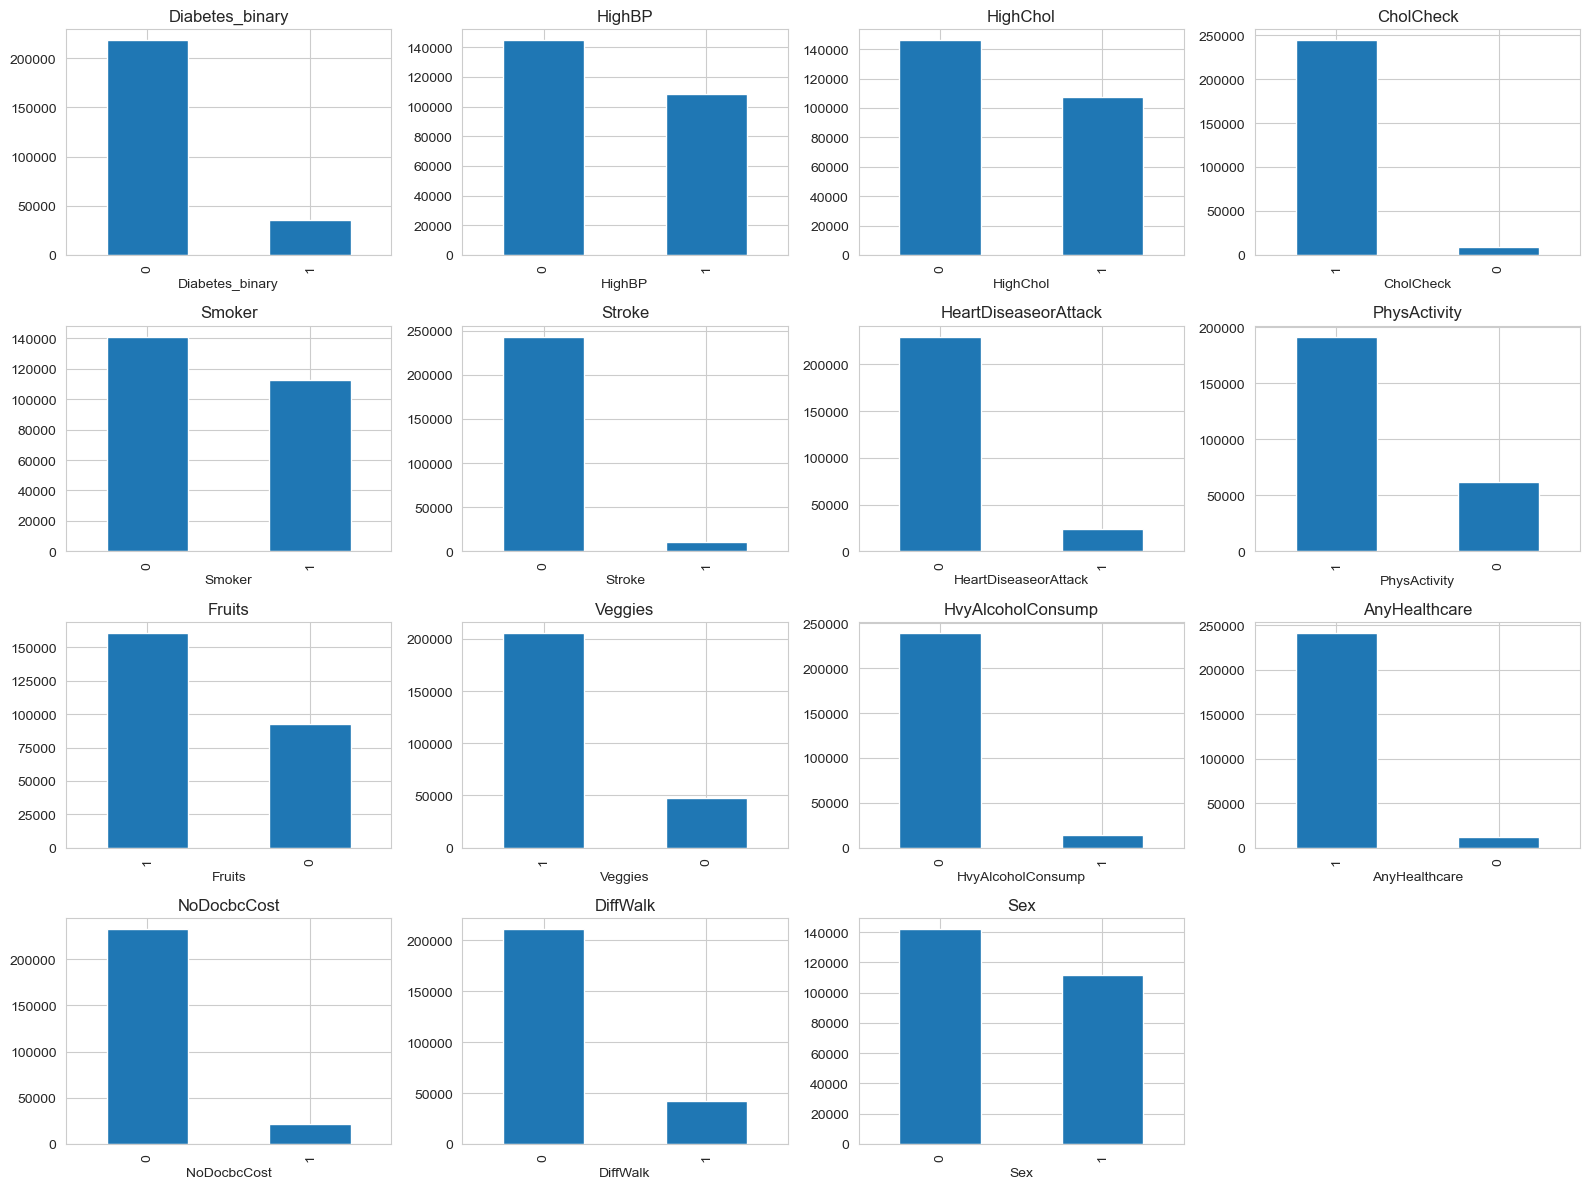

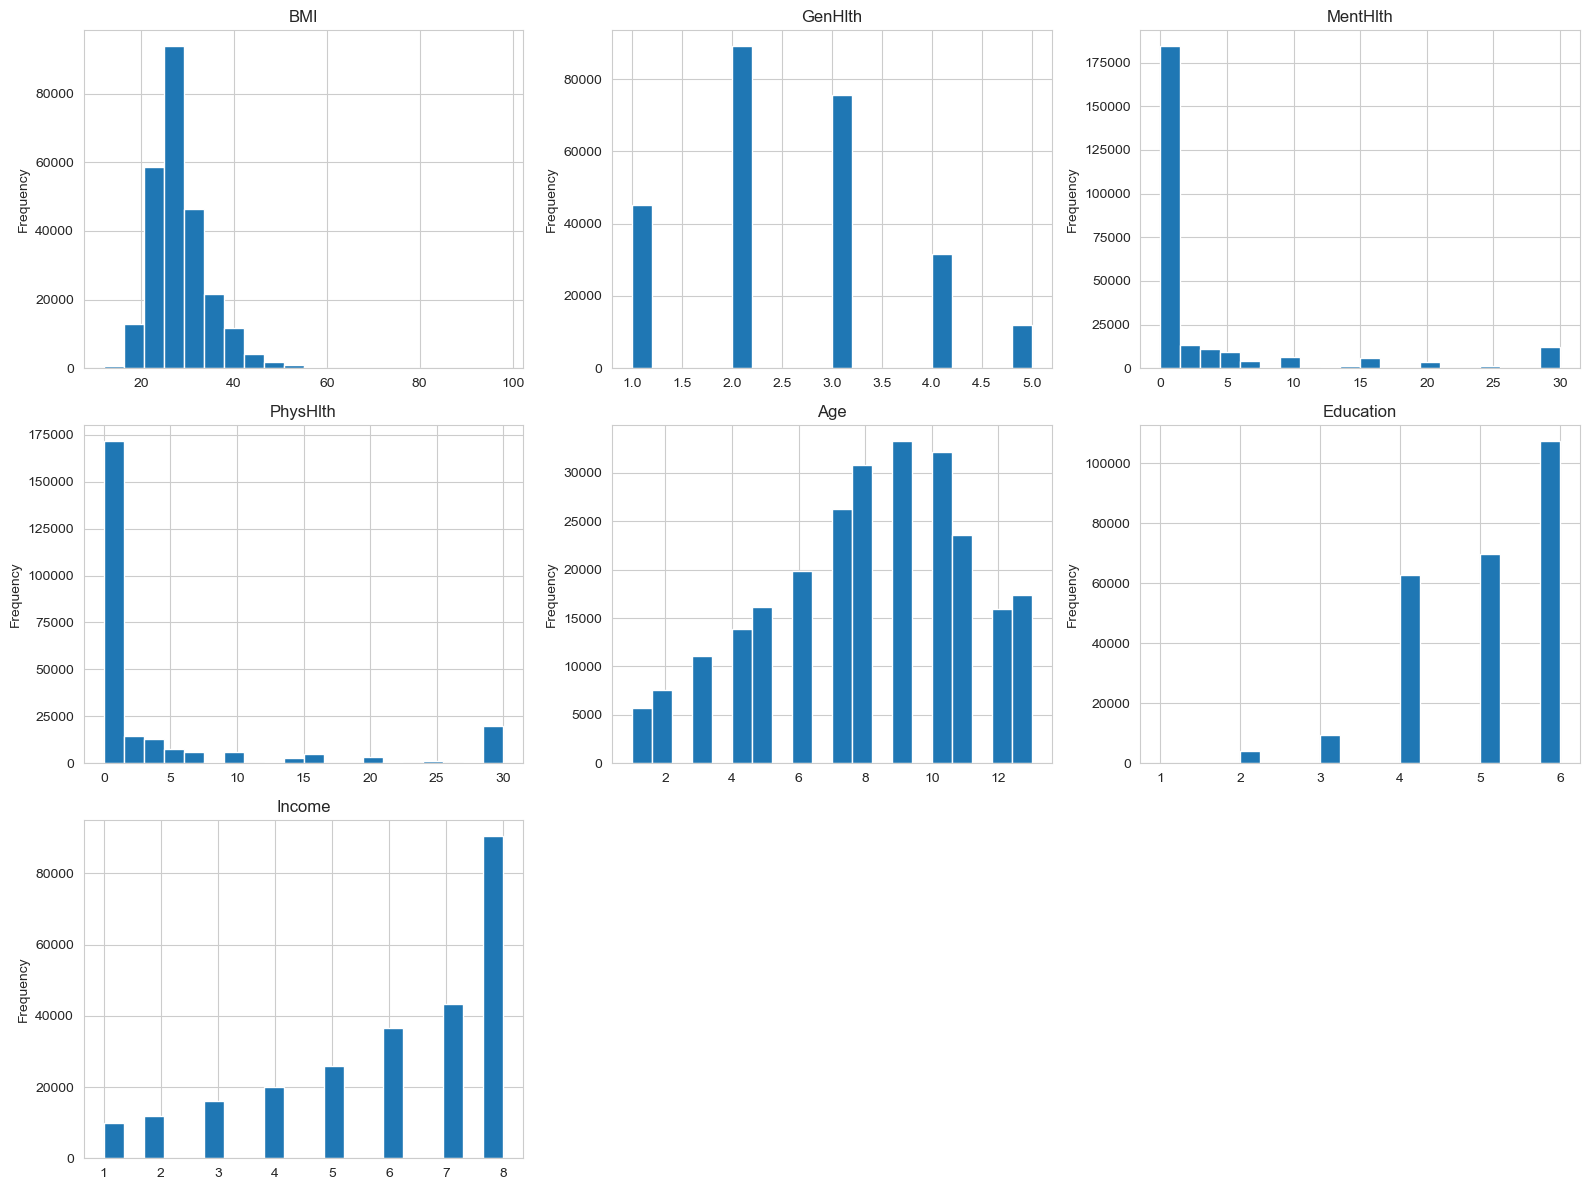

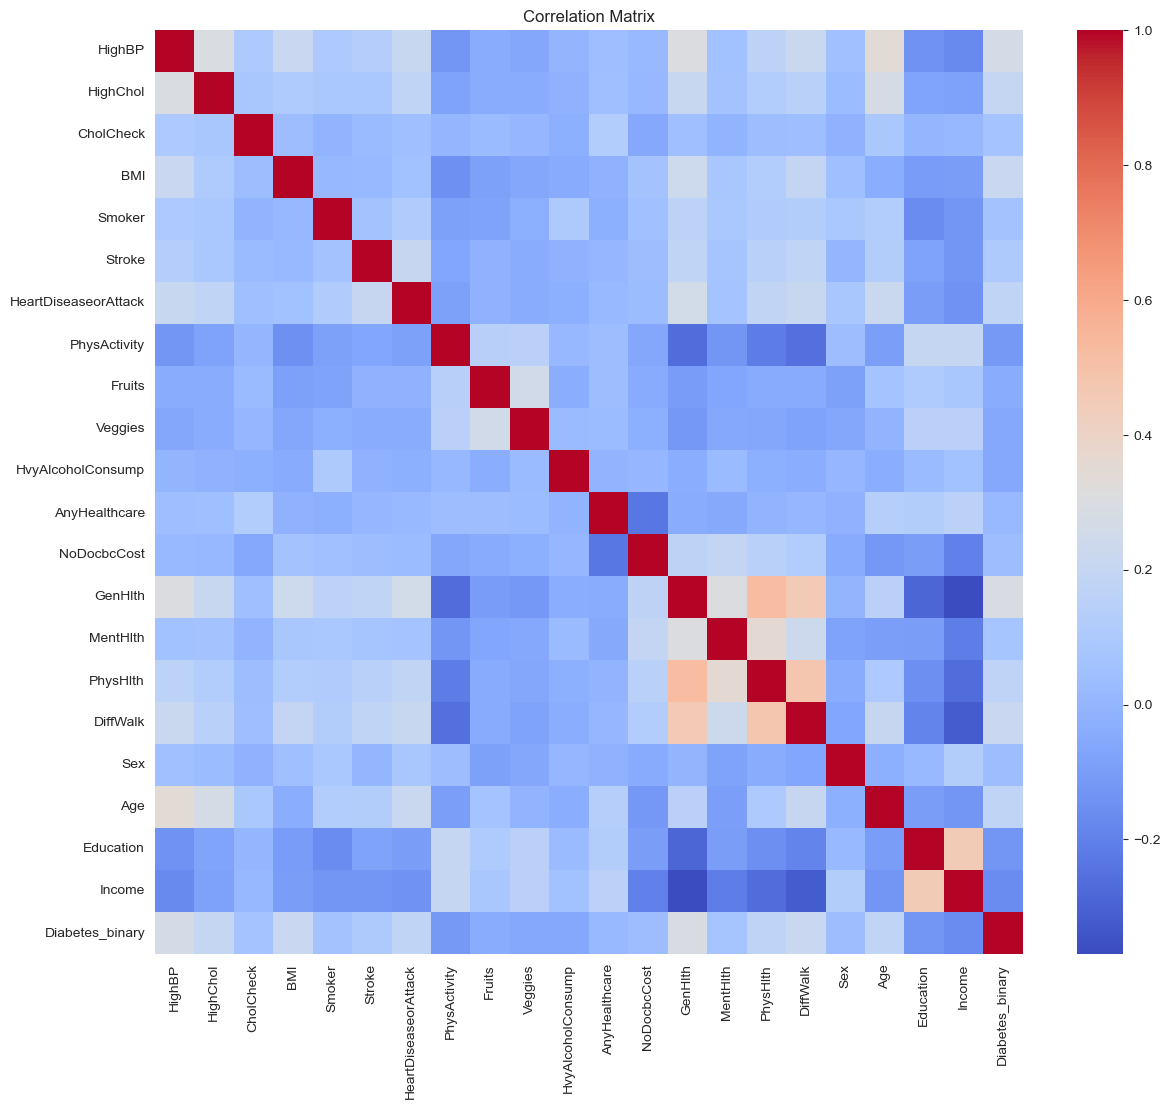

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.concat([X, y], axis=1)
print("===== DATA SHAPE =====")
print(df.shape)

print("\n===== DATA INFO =====")
print(df.info())

print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

print("\n===== VALUE RANGES =====")
for col in df.columns:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}, unique={df[col].nunique()}")

binary_cols = [
    'Diabetes_binary','HighBP','HighChol','CholCheck','Smoker','Stroke',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex'
]

integer_cols = [
    'BMI','GenHlth','MentHlth','PhysHlth','Age','Education','Income'
]

id_cols = ['ID']

print("\n===== FEATURE GROUPS =====")
print("Binary features:", binary_cols)
print("Integer (ordered/categorical) features:", integer_cols)
print("ID columns:", id_cols)

plt.figure(figsize=(16, 12))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(4, 4, i)
    df[col].value_counts().plot(kind="bar")
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(integer_cols, 1):
    plt.subplot(3, 3, i)
    df[col].plot(kind='hist', bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#use trained model if set to true
useSaved = False

# drop unused data
# X = X.drop(columns=["GenHlth", "PhysHlth", "MentHlth"])

#Data cleaning (so it plays nice with pgmpy)
#convert BMI into underweight, normal, overweight, obese, and extremely obese (respectively 0 through 4)
X.loc[:, "BMI"] = pd.cut(
    X.loc[:, "BMI"],
    bins=[0, 18.5, 25, 30, 35, float("inf")],
    labels=[0, 1, 2, 3, 4]
).astype(int)

#shift age to be 0 through 12 instead of 1 through 13
X.loc[:, "Age"] = X.loc[:, "Age"] - 1

#shift education to be 0 through 5 instead of 1 through 6
X.loc[:, "Education"] = X.loc[:, "Education"] - 1

#shift income to be 0 through 7 instead of 1 through 8 
X.loc[:, "Income"] = X.loc[:, "Income"] - 1

# GenHlth: 1–5 → 0 ("good"), 1 ("average"), 2 ("poor")
X.loc[:, "GenHlth"] = pd.cut(
    X["GenHlth"],
    bins=[0, 2, 3, 5],       # (0,2], (2,3], (3,5]
    labels=[0, 1, 2]
).astype(int)

# MentHlth: 0–30 days → good / medium / poor
X.loc[:, "MentHlth"] = pd.cut(
    X["MentHlth"],
    bins=[-1, 5, 15, 30],    # (-1,5], (5,15], (15,30]
    labels=[0, 1, 2]
).astype(int)

# PhysHlth: 0–30 days → good / medium / poor
X.loc[:, "PhysHlth"] = pd.cut(
    X["PhysHlth"],
    bins=[-1, 5, 15, 30],
    labels=[0, 1, 2]
).astype(int)

#split data into train-test-validate
X_train, X_test_validate, y_train, y_test_validate = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate, train_size=0.5, random_state=42)

if useSaved == False:
    #establish BN 
    model = DiscreteBayesianNetwork(
        [
            #variables connecting to physical health latent variable
            ("HighBP", "PhysicalHealth"),
            ("HighChol", "PhysicalHealth"),
            ("BMI", "PhysicalHealth"), 
            ("PhysActivity", "PhysicalHealth"),
            
            # concurrent symptoms
            ("DiffWalk", "ConcurrentSymptoms"),
            ("HeartDiseaseorAttack", "ConcurrentSymptoms"),
            ("Stroke", "ConcurrentSymptoms"),

            #varaibles connecting to diet latent variable
            ("Fruits", "Diet"),
            ("Veggies", "Diet"),
            ("HvyAlcoholConsump", "Diet"),
            ("Smoker", "Diet"),

            #variables connecting to healthcare access latent variable
            ("AnyHealthcare", "HealthcareAccess"),
            ("NoDocbcCost", "HealthcareAccess"),
            ("CholCheck", "HealthcareAccess"),

            #variables connecting to socioeconomic status latent variable
            ("Sex", "SocioeconomicStatus"),
            ("Age", "SocioeconomicStatus"),
            ("Education", "SocioeconomicStatus"),
            ("Income", "SocioeconomicStatus"),

            # variables connecting to self-reported status latent variable
            ("GenHlth", "SelfreportedStatus"),
            ("PhysHlth", "SelfreportedStatus"),
            ("MentHlth", "SelfreportedStatus"),

            #latent variables connecting to final diagnosis
            ("PhysicalHealth", "Diabetes_binary"),
            ("Diet", "Diabetes_binary"),
            ("HealthcareAccess", "Diabetes_binary"),
            ("SocioeconomicStatus", "Diabetes_binary"),
            ("SelfreportedStatus", "Diabetes_binary"),
            ("ConcurrentSymptoms", "Diabetes_binary")
        ],
        latents={"PhysicalHealth", "Diet", "ConcurrentSymptoms","SelfreportedStatus","HealthcareAccess", "SocioeconomicStatus"} 
    )

    #get cardinalities from data
    cardinalities = {col: X[col].nunique() for col in X.columns} #cardinalities taken from number of unique values in data
    cardinalities.update({"Diabetes_binary" : 2}) #No diabetes or prediabetes, no diabetes or prediabetes
    cardinalities.update({"PhysicalHealth" : 3}) #bad, neutral, good
    cardinalities.update({"Diet" : 3}) #bad, neutral, good
    cardinalities.update({"HealthcareAccess" : 3}) #None, poor, good 
    cardinalities.update({"SocioeconomicStatus" : 3}) #Lower class, middle class, upper class
    cardinalities.update({"SelfreportedStatus": 3})  # bad, neutral, good
    cardinalities.update({"ConcurrentSymptoms": 3})  # none, few, many
    
    print(cardinalities)

    #generate CPTs for each node
    cpts = []
    for var in model.nodes(): 
        var_card = cardinalities[var]
        parents = model.get_parents(var) #read the parents of the node

        #variable has no parents
        if len(parents) == 0:
            probs = np.random.dirichlet(np.ones(var_card)) #uniform distribution initialization
            cpts.append(TabularCPD(variable = var, variable_card = var_card, values = np.transpose([probs])))
        #variable has parents
        else:
            parent_cards = [cardinalities[parent] for parent in parents] #get the cardinalities of each parent of the node into a list
            num_parent_configs = np.prod(parent_cards)

            probs = np.zeros((var_card, num_parent_configs))

            for col in range(num_parent_configs): #define a uniform distribution for each parent configuration
                probs[:, col] = np.random.dirichlet(np.ones(var_card))

            cpts.append(TabularCPD(variable = var, variable_card = var_card, values = probs, evidence=parents, evidence_card = parent_cards))

    model.add_cpds(*cpts)

    #check model for faults
    model.check_model()

In [ ]:
#train EM 
if useSaved == False: 
    train_combined = X_train.join(y_train) #combine X_train and y_train together
    small_train_combined = train_combined.sample(20000)
    model.fit(data=small_train_combined, estimator=ExpectationMaximization)

    model.save("model_Chenrui.bif", filetype="bif")
else: 
    model = DiscreteBayesianNetwork.load("model_Chenrui.bif", fyletype ="bif")

model_infer = VariableElimination(model)

In [ ]:
#validation set
preds_val = []

for _, row in X_validate.iterrows():
    evidence = {k: str(v) for k, v in row.to_dict().items()} #convert from int to str because pgmpy is fussy
    q = model_infer.query(["Diabetes_binary"], evidence=evidence)
    preds_val.append(int(q.values.argmax()))

print(accuracy_score(y_validate, preds_val))

In [ ]:
#test set
preds_test = []

for _, row in X_test.iterrows():
    evidence = {k: str(v) for k, v in row.to_dict().items()} #convert from int to str because pgmpy is fussy
    q = model_infer.query(["Diabetes_binary"], evidence=evidence)
    preds_test.append(int(q.values.argmax()))
 
print(accuracy_score(y_test, preds_test))